# Interpolation Testbed Notebook

Short notebook to test various interpolation strategies. 

In [1]:
import sys 

import numpy as np
import matplotlib.pyplot as plt

from scipy.interpolate import griddata

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from sklearn.preprocessing import MinMaxScaler

from sklearn.ensemble import RandomForestRegressor

import xarray as xr

In [2]:
sys.path.insert(1, '../sealsml')

In [3]:
from baseline import create_meshgrid, find_closest_values_with_indices, nanargmax_to_one
from baseline import ScipyInterpolate, GaussianProcessInterpolator, RandomForestInterpolator

## Random Sensor and Leak Grab

In [4]:
num_sensors = 14

In [5]:
random_x = np.random.choice(30, size=num_sensors, replace=False )  
random_y = np.random.choice(30, size=num_sensors, replace=False )   
print('x locations', random_x)
print('y locations', random_y)

x locations [27  4 25 24 26 23 19  5 17  9 12 15 13  6]
y locations [ 0  3 16 17 23 20 21 22  1  2  5 18 12 27]


In [6]:
num_leaks = 5

In [7]:
random_x_leak = np.random.choice(30, size=num_leaks-1, replace=False )  
random_y_leak = np.random.choice(30, size=num_leaks-1, replace=False )  

random_x_leak = np.append(random_x_leak, 15)
random_y_leak = np.append(random_y_leak, 15)

print('x locations', random_x_leak)
print('y locations', random_y_leak)

x locations [ 7 25 18  6 15]
y locations [29 17 18  5 15]


## Loading in real data

Since none of these need to be 'trained', if it works on one dataset, it will work on all of them. 

In [8]:
data = '../data/SBL2m_Ug10_src10kg_a.6'

In [9]:
ds = xr.open_dataset(data)
ds

<xarray.Dataset>
Dimensions:                (time: 361, srcDim: 1, locDim: 3, kDim: 15,
                            jDim: 30, iDim: 30, timeDim: 361)
Coordinates:
  * time                   (time) float32 2.88e+04 2.881e+04 ... 3.06e+04
Dimensions without coordinates: srcDim, locDim, kDim, jDim, iDim, timeDim
Data variables:
    srcAuxScLocation       (srcDim, locDim) float64 ...
    srcAuxScMassSpecValue  (srcDim) float64 ...
    structureMask          (kDim, jDim, iDim) float64 ...
    xPos                   (kDim, jDim, iDim) float32 ...
    yPos                   (kDim, jDim, iDim) float32 ...
    zPos                   (kDim, jDim, iDim) float32 ...
    u                      (timeDim, kDim, jDim, iDim) float32 ...
    v                      (timeDim, kDim, jDim, iDim) float32 ...
    w                      (timeDim, kDim, jDim, iDim) float32 ...
    q_CH4                  (time, kDim, jDim, iDim) float32 ...

In [10]:
z_level = 1

In [11]:
x_pos = ds.xPos.sel(iDim=random_x, jDim=random_y, kDim = [z_level]).values.squeeze()
x_pos = x_pos.diagonal()

In [12]:
x_pos_leak = ds.xPos.sel(iDim=random_x_leak, jDim=random_y_leak, kDim = [z_level]).values.squeeze()
x_pos_leak = x_pos_leak.diagonal()

In [13]:
y_pos = ds.yPos.sel(iDim=random_x, jDim=random_y, kDim = [z_level]).values.squeeze()
y_pos = y_pos.diagonal()

In [14]:
y_pos_leak = ds.yPos.sel(iDim=random_x_leak, jDim=random_y_leak, kDim = [z_level]).values.squeeze()
y_pos_leak = y_pos_leak.diagonal()

In [15]:
z_pos = ds.zPos.sel(iDim=random_x, jDim=random_y, kDim = [z_level]).values.squeeze()
z_pos = z_pos.diagonal()

In [16]:
data = ds.q_CH4.sel(iDim=random_x, jDim=random_y, kDim = [z_level]).values.squeeze()
print('shape of data', np.shape(data))

shape of data (361, 14, 14)


In [17]:
percentile_80 = np.percentile(data, 80, axis=0)
np.shape(percentile_80)

(14, 14)

In [18]:
scaler = MinMaxScaler()
ch4_data = scaler.fit_transform(percentile_80.diagonal().reshape(-1,1)).squeeze()
np.shape(ch4_data)

(14,)

## Create x and y locations

#### Quick Plot

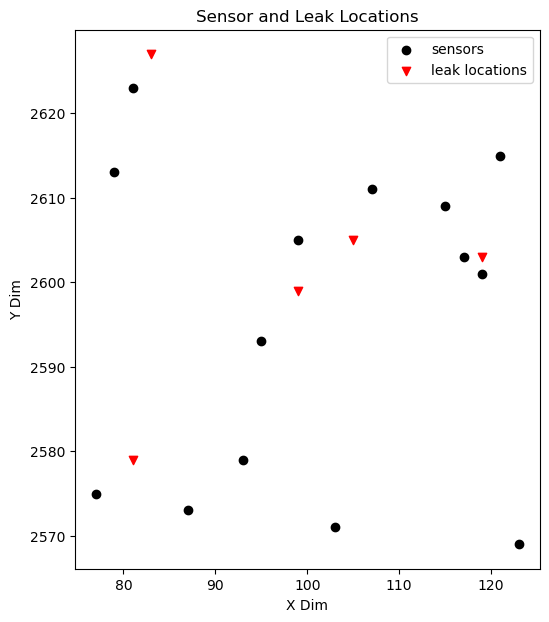

In [19]:
plt.figure(figsize=(6, 7))

plt.scatter(x_pos, y_pos, label='sensors', color='black')
plt.scatter(x_pos_leak, y_pos_leak, marker="v", label='leak locations', color='red')

plt.legend()
plt.xlabel('X Dim')
plt.ylabel('Y Dim')
plt.title('Sensor and Leak Locations')

plt.show()

This is just for this toy problem, won't be used for the actual code as it will come from the data loader as built by C Becker.

## Interpolate the Data

First step is creating a new meshgrid that is more dense

In [20]:
x_new, y_new = create_meshgrid(x_pos, y_pos, buffer=6, grid_points=100)

#### Create X and y training data

In [21]:
X_train = np.column_stack((x_pos, y_pos))
y_train = ch4_data

# new mesh data points
X_test = np.column_stack((x_new.ravel(), y_new.ravel()))
np.shape(X_test)

(10000, 2)

## SciPy Interpolator

In [22]:
scipy_model = ScipyInterpolate()
scipy_model.fit(X_train, y_train)

In [23]:
z_interpolated = scipy_model.predict(X_test)

print('type:', type(z_interpolated))
print('size:', np.shape(z_interpolated))

max_z = np.nanmax(z_interpolated)
max_indices = np.where(z_interpolated == max_z)

type: <class 'numpy.ndarray'>
size: (100, 100)


## Using Scikit-learn methods

### Gaussian Processes Regressor

In [24]:
gp_mo = GaussianProcessInterpolator()
gp_mo.fit(X_train, y_train)

In [25]:
reshaped_gp_results = gp_mo.predict(X_test)

print('type:', type(reshaped_gp_results))
print('size:', np.shape(reshaped_gp_results))

max_z_gp = np.nanmax(reshaped_gp_results)
max_indices_gp = np.where(max_z_gp == reshaped_gp_results)

type: <class 'numpy.ndarray'>
size: (100, 100)


#### Random Forest Model

In [26]:
rf_mo = RandomForestInterpolator()
rf_mo.fit(X_train, y_train)

In [27]:
reshaped_rf_results = rf_mo.predict(X_test)

print('type:', type(reshaped_rf_results))
print('size:', np.shape(reshaped_rf_results))

max_z_rf = np.nanmax(reshaped_rf_results)
max_indices_rf = np.where(max_z_rf == reshaped_rf_results)

type: <class 'numpy.ndarray'>
size: (100, 100)


## Find which sensor has the highest value

In [28]:
closest_values_x, indicies_x = find_closest_values_with_indices(x_pos_leak, x_new.diagonal())
closest_values_x

[82.71717171717171,
 119.04040404040404,
 104.97979797979798,
 80.95959595959596,
 99.12121212121212]

In [29]:
closest_values_y, indicies_y = find_closest_values_with_indices(y_pos_leak, y_new.diagonal())
closest_values_y

[2627.0, 2603.0, 2605.0, 2579.0, 2599.0]

In [30]:
scipy_ = z_interpolated[indicies_x, indicies_y]
gp_    = reshaped_gp_results[indicies_x, indicies_y]
rf_    = reshaped_rf_results[indicies_x, indicies_y]

In [31]:
print("Which Leak location is most likely? - Using Standard Interpolator")
index_of_max_value = np.where(nanargmax_to_one(scipy_) == 1)[0][0]
print("Index of the maximum value (ignoring NaN) is:", index_of_max_value)

Which Leak location is most likely? - Using Standard Interpolator
Index of the maximum value (ignoring NaN) is: 2


In [32]:
print("Which Leak location is most likely - Using Gaussian processes?")
index_of_max_value_gp = np.where(nanargmax_to_one(gp_) == 1)[0][0]
print("Index of the maximum value (ignoring NaN) is:", index_of_max_value_gp)

Which Leak location is most likely - Using Gaussian processes?
Index of the maximum value (ignoring NaN) is: 2


In [33]:
print("Which Leak location is most likely - Using Random Forest?")
index_of_max_value_rf = np.where(nanargmax_to_one(rf_) == 1)[0][0]
print("Index of the maximum value (ignoring NaN) is:", index_of_max_value_rf)

Which Leak location is most likely - Using Random Forest?
Index of the maximum value (ignoring NaN) is: 2


## Comparison Plot

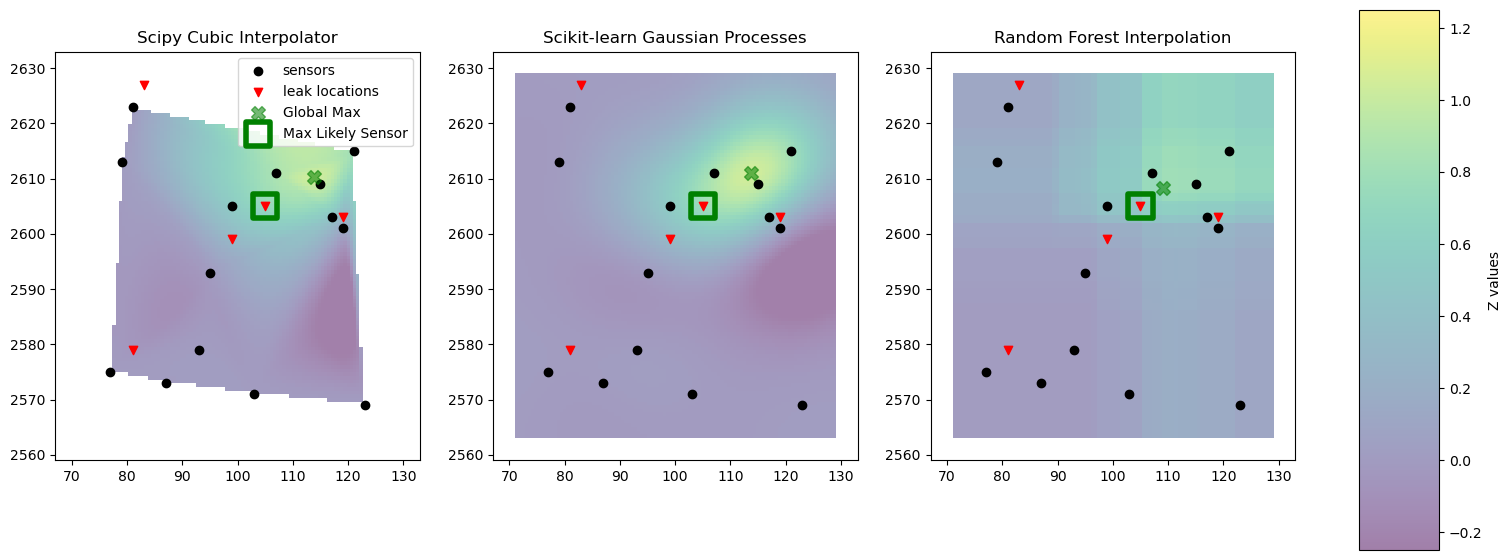

In [34]:
# Calculate the overall minimum and maximum values for the color bar range
buffer = 6

global_min = np.round(np.min(ch4_data), 2) - 0.25
global_max = np.round(np.max(ch4_data), 2) + 0.25

fig, axes = plt.subplots(1, 3, figsize=(16, 12))

# Common settings for all subplots
for ax in axes:
    ax.scatter(x_pos, y_pos, label='sensors', color='black')
    ax.scatter(x_pos_leak, y_pos_leak, marker="v", label='leak locations', color='red')
    ax.set_xlim(min(x_pos - buffer - 4), max(x_pos + buffer + 4))
    ax.set_ylim(min(y_pos - buffer - 4), max(y_pos + buffer + 4))

# Plot 1 - First Block
img = axes[0].imshow(z_interpolated.T, extent=(min(x_pos - buffer), max(x_pos + buffer), min(y_pos - buffer), max(y_pos + buffer)),
                    origin='lower', cmap='viridis', alpha=0.5)

img.set_clim(global_min, global_max)  # Set color bar range

axes[0].scatter(x_new[max_indices[0][0]][0], y_new[0][max_indices[1][0]], marker="X", label='Global Max', color='Green', s=100, alpha=0.55)
axes[0].scatter(x_pos_leak[index_of_max_value], y_pos_leak[index_of_max_value], marker="s", label='Max Likely Sensor', color='Green', facecolors='none', s=300, linewidths=4)
axes[0].legend()
axes[0].set_title('Scipy Cubic Interpolator')

# Plot 2 - Second Block
img2 = axes[1].imshow(reshaped_gp_results.T, extent=(min(x_pos - buffer), max(x_pos + buffer), min(y_pos - buffer), max(y_pos + buffer)),
                    origin='lower', cmap='viridis', alpha=0.5)

img2.set_clim(global_min, global_max)

axes[1].scatter(x_pos_leak[index_of_max_value_gp], y_pos_leak[index_of_max_value_gp], marker="s", label='Max Likely Sensor', color='Green', facecolors='none', s=300, linewidths=4)
axes[1].scatter(x_new[max_indices_gp[0][0]][0], y_new[0][max_indices_gp[1][0]], marker="X", label='Global Max', color='Green', s=100, alpha=0.55)
axes[1].set_title('Scikit-learn Gaussian Processes')

# Third Across
img3 = axes[2].imshow(reshaped_rf_results.T, extent=(min(x_pos - buffer), max(x_pos + buffer), min(y_pos - buffer), max(y_pos + buffer)),
                    origin='lower', cmap='viridis', alpha=0.5)

img3.set_clim(global_min, global_max)

axes[2].scatter(x_new[max_indices_rf[0][0]][0], y_new[0][max_indices_rf[1][0]], marker="X", label='Global Max', color='Green', s=100, alpha=0.55)
axes[2].scatter(x_pos_leak[index_of_max_value_rf], y_pos_leak[index_of_max_value_rf], marker="s", label='Max Likely Sensor', color='Green', facecolors='none', s=300, linewidths=4)
axes[2].set_title('Random Forest Interpolation')

# Add colorbar
cbar_ax = fig.add_axes([.94, 0.25, 0.05, 0.45])  # [x, y, width, height]
cbar = plt.colorbar(img, cax=cbar_ax)
cbar.set_label('Z values')

# plt.tight_layout()
plt.show()